# Optimal Unitary Gate 

This notebook will serve as a test ground for implementing an optimal unitary gate in a dissapative quantum system.

In [712]:
# Import libraries
import numpy as np

import time

import torch
from torch import nn
from torch.autograd import Variable
# import torch.optim.lr_scheduler as lr_scheduler

# from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

import plotly.graph_objs as go

In [713]:
# Choose device to run on ... enable GPU soon.
device = torch.device("cpu")

# Define data type for torch
exp_dtype = torch.complex64

In [714]:
# Define Pauli matrices for two level system
sigma_x = torch.tensor([[0,1],[1,0]], dtype=exp_dtype).to(device) 
sigma_y = torch.tensor([[0,-1j],[1j,0]], dtype=exp_dtype).to(device) 
sigma_z = torch.tensor([[1,0],[0,-1]], dtype=exp_dtype).to(device) 
sigma_plus = torch.tensor([[0, 1], [0, 0]], dtype=exp_dtype).to(device) 
sigma_minus = torch.tensor([[0, 0], [1, 0]], dtype=exp_dtype).to(device) 
I = torch.eye(2, dtype=exp_dtype).to(device) 

# Multiple spin operators, basically just sandwiches the kth spin operator between the necessary amount of identities
def X_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_x
        ), torch.eye(2**(N-(k)))
    )

def Y_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_y
        ), torch.eye(2**(N-(k)))
    )

def Z_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_z
        ), torch.eye(2**(N-(k)))
    )

def sigma_plus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_plus
        ), torch.eye(2**(N-(k)))
    )

def sigma_minus_k(k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), sigma_minus
        ), torch.eye(2**(N-(k)))
    )

# Same idea just for arbitrary unitary for N spins
def U_k(U, k, N):
    return torch.kron(
        torch.kron(
            torch.eye(2**(k-1)), U
        ), torch.eye(2**(N-(k)))
    )

In [715]:
# Plotting help
def bloch_animation(spin_num, rhos, rho_final, plot=False, bloch_sphere=False): 
    x,y,z,r=[],[],[],[] 
    for rho in rhos:
        X = np.real(np.trace(np.dot(rho, X_k(spin_num, N))))
        Y = np.real(np.trace(np.dot(rho, Y_k(spin_num, N))))
        Z = np.real(np.trace(np.dot(rho, Z_k(spin_num, N))))
        R = np.sqrt(X**2 + Y**2 + Z**2)
        x.append(X)
        y.append(Y) 
        z.append(Z)
        r.append(R)

    X_F = np.real(np.trace(np.dot(rho_final, X_k(spin_num, N))))
    Y_F = np.real(np.trace(np.dot(rho_final, Y_k(spin_num, N))))
    Z_F = np.real(np.trace(np.dot(rho_final, Z_k(spin_num, N))))

    if plot:
            plt.plot(t_units, x, c='r', label=r"$x(t)$")
            plt.plot(t_units, y, c='b', label=r"$y(t)$")
            plt.plot(t_units, z, c='g', label=r"$z(t)$")
            plt.title("Spin #{}".format(spin_num))
            plt.legend(loc='best')
            plt.savefig("./results/spin_{}_xyz_state.png".format(spin_num), dpi=300, bbox_inches="tight")
            plt.show()

            plt.plot(t_units, r, c='k', label=r"$r(t)$")
            plt.title("R Value")
            plt.ylim([0,2])
            plt.legend(loc='best')
            plt.savefig("./results/spin_{}_r_value.png".format(spin_num), dpi=300, bbox_inches="tight")
            plt.show()

            print(f"Starting: [{x[0]}, {y[0]}, {z[0]}] \n")
            print(f"Ending: [{x[-1]}, {y[-1]}, {z[-1]}]")


    if bloch_sphere:
        data = [go.Scatter3d(x=x, y=y, z=z,
                            mode="markers",
                            marker=dict(size=3)), go.Scatter3d(x=[X_F], y=[Y_F], z=[Z_F],
                            mode="markers",
                            marker=dict(size=6)),
                            go.Scatter3d(x=[x[0]], y=[y[0]], z=[z[0]],
                            mode="markers",
                            marker=dict(size=6))]
        fig = go.Figure(data = data)
        u = np.linspace(0, 2*np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        sphere = go.Surface(x=x, y=y, z=z, opacity=0.2, colorscale='Greys', showscale=False)
        fig.add_trace(sphere)

        # Update layout with axis labels
        fig.update_layout(scene=dict(
            xaxis=dict(title='Y'),
            yaxis=dict(title='X'),
            zaxis=dict(title='Z')
        ))
        fig.show()
    
    else:
        return r


In [716]:
# Number of spins
N = 2
isDispersive = False
on_resonance = False

In [717]:
# Dice up the time
Ti, Tf = 0, 1e-6 # seconds
dt = 0.5e-8 # seconds, notice we fix dt rather than M and that's because it is used in the L calculation
M = int((Tf-Ti)/dt)
t_units = np.arange(Ti, Tf, dt) # Array for plotting

/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_10358/1568557522.py:107: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



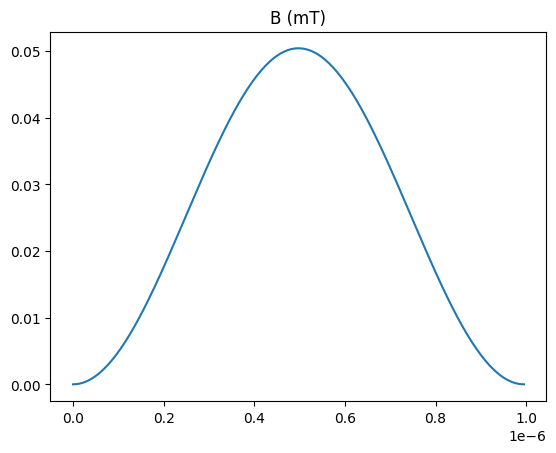

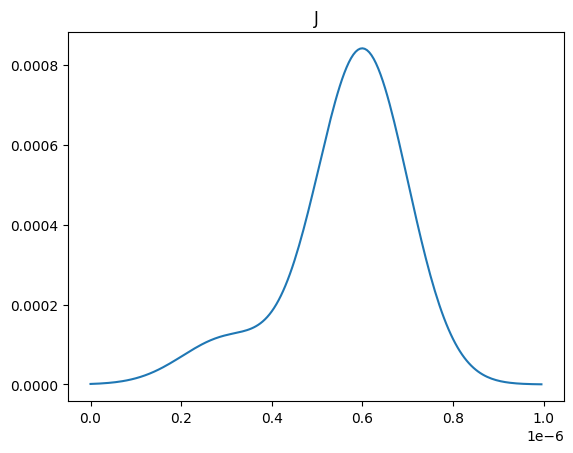

torch.Size([2, 200])


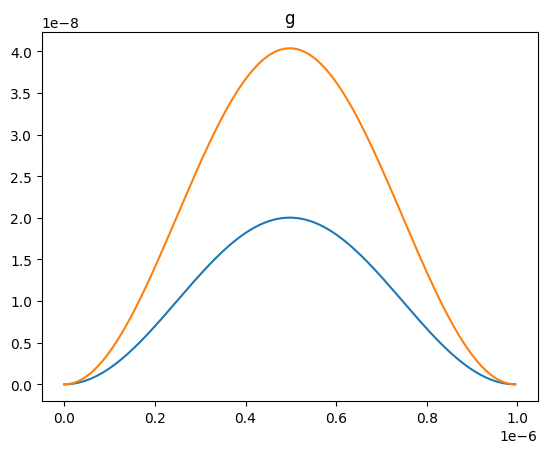

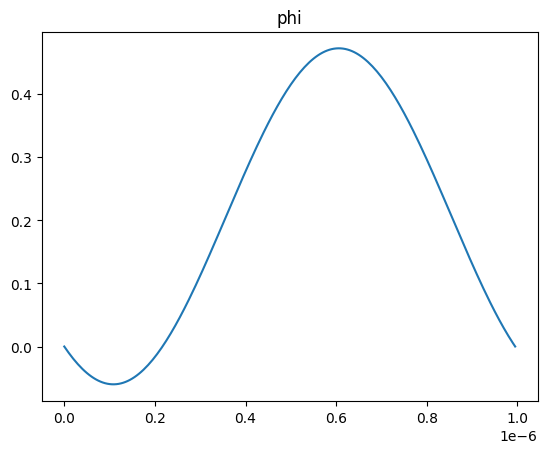

In [718]:
# Fourier series expansion
def fourier_series(scale, t,*coeffs):
    n = len(coeffs[0])
    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t, dtype=torch.float32) 
    a = coeffs[0][:n//2]
    b = coeffs[0][n//2:]
    for i in range(len(a)):
        f += a[i].repeat(len(t)) * np.sin(i * omega * t) / scale
    for i in range(len(b)):
        f += b[i].repeat(len(t)) * np.cos(i * omega * t)/ scale
    f -= torch.sum(b).repeat(len(t)) * np.cos(i * omega * t)/ scale # ensures start and stop @ zero
    return f

def g_fourier_series(scale, t, *coeffs):
    num_of_g = coeffs[0].shape[0]
    all_gs = []
    for i in range(num_of_g):
        all_gs.append(fourier_series(scale, t, coeffs[0][i]))
    return all_gs

def phi_fourier_series(t, *coeffs):
    # adds offset since phi doesnt have to start and stop @ zero.
    n = len(coeffs[0])

    omega = 2 * np.pi / (t[-1]-t[0])
    f = torch.zeros_like(t, dtype=torch.float32)
    # f += coeffs[0][-1]
    a = coeffs[0][:n//2]
    b = coeffs[0][n//2:]

    for i in range(len(a)):
        f += a[i].repeat(len(t)) * np.sin(i * omega * t) / 2
    for i in range(len(b)):
        f += b[i].repeat(len(t)) * np.cos(i * omega * t) / 2
    f -= torch.sum(b).repeat(len(t)) * np.cos(i * omega * t) / 2 # ensures start and stop @ zero
    return f

K = 2 # Number of harmonics
B_rf_scale = 1e5
g_scale = 1e7

B_rf_coeffs = Variable(torch.tensor(np.random.randn(2 * K-1), dtype=torch.float32), requires_grad=True)  
phi_coeffs = Variable(torch.tensor(np.random.randn(2 * K), dtype=torch.float32), requires_grad=True) 

t_units_tensor = torch.tensor(t_units)

B_rf = fourier_series(B_rf_scale, t_units_tensor, B_rf_coeffs)
phi = phi_fourier_series(t_units_tensor, phi_coeffs)

# g = []
# g_fourier = g_fourier_series(t_units_tensor, g_coeffs)
# for g_ in g_fourier:
#     g.append(Variable(torch.tensor(g_, dtype=exp_dtype), requires_grad=True))

# B_rf = Variable(torch.tensor(B_rf, dtype=exp_dtype), requires_grad=True)
# phi = Variable(torch.tensor(phi, dtype=exp_dtype), requires_grad=True)

J_scale = 2e3/((6.242e-18) * 1e-6) # ~ 0.05 ueV

def construct_g_signal(t, sigma, *coeffs):
    g = torch.zeros_like(t, dtype=torch.float32)
    skip = int(2.5 * sigma // dt) # skip 2.5 standard deviations to ensure start and stop @ basically zero
    step = skip
    for i in range(skip, M-skip,step):
        gaussian = torch.exp(-(t - i * dt)**2 / (2 * sigma**2)) / g_scale
        g += coeffs[0][i].repeat(len(t)) * gaussian
    return g

def build_g(t, sigma, *coeffs):
    num_of_g = coeffs[0].shape[0]
    all_gs = []
    for i in range(num_of_g):
        all_gs.append(construct_g_signal(t, sigma, coeffs[0][i]))
    return all_gs

def construct_J_signal(t, sigma, skip, *coeffs):
    J = torch.zeros_like(t, dtype=exp_dtype)
    
    step = skip

    for i in range(skip, M-skip, step):
        gaussian = torch.exp(-(t - i * dt)**2 / (2 * sigma**2)) / J_scale
        J += coeffs[0][i//skip-1 ].repeat(len(t)) * gaussian
    return J.unsqueeze(0)

def build_J(t, sigma, skip, *coeffs):
    num_of_J = coeffs[0].shape[0]
    all_Js = []
    for i in range(num_of_J):
        all_Js.append(construct_J_signal(t, sigma, skip, coeffs[0][i]))
    return all_Js


g_sigma = 20

g_coeffs =  Variable(torch.tensor(np.random.randn(N, M), dtype=torch.float32), requires_grad=True) # Random initial coefficients

g_gaussian = False
if g_gaussian:
    g = build_g(t_units_tensor, g_sigma * dt ,torch.abs( g_coeffs))
else:
    g_coeffs =  Variable(torch.tensor(np.random.randn(N, 2 * K -1), dtype=torch.float32), requires_grad=True) 
    g = []
    g_fourier = g_fourier_series(g_scale,t_units_tensor, g_coeffs)
    for g_ in g_fourier:
        g.append(torch.tensor(g_, dtype=torch.float32).unsqueeze(0))

if len(g) == 1:
    g = g[0]
else:
    g = torch.cat(g, dim=0)

J_sigma = 20

skip = int(3 * J_sigma) # skip 2.5 standard deviations to ensure start and stop @ basically zero
J_coeffs =  Variable(torch.tensor(np.random.randn(N-1, M//skip), dtype=torch.float32), requires_grad=True) # Random initial coefficients

J = build_J(t_units_tensor, J_sigma * dt, skip, torch.abs(J_coeffs))

if len(J) == 0:
    pass
elif len(J) == 1:
    J = J[0]
else:
    J = torch.cat(J, dim=0)

plt.plot(t_units, B_rf.cpu().detach().numpy()/1e-3)
plt.title("B (mT)")
plt.show()

if N>=2:
    for i in range(J.shape[0]):
        plt.plot(t_units, J[i].cpu().detach().numpy()/((6.242e-18) * 1e-6))
    plt.title("J")
    plt.show()

print(g.shape)
for i in range(g.shape[0]):
    plt.plot(t_units, g[i].cpu().detach().numpy())
plt.title("g")
plt.show()


plt.plot(t_units, phi.cpu().detach().numpy())
plt.title("phi")
plt.show()



In [719]:
# Define constants
muB = 9.27e-24 # J/T
hbar = 1.055e-34 # Js
B0 = 607.285 * 1e-3 # Tesla, Bohdan's thesis page 120
kB = 1.38e-23 # J/K
w = 2 * muB * B0 / hbar # Larmor freq
f_rf = 17e9 # Hz
w_rf = 2 * np.pi * f_rf if not(on_resonance) else w 

# Define Lindblad operators
Te = 4 # K
T1 = 10e-3 # seconds
T2 = 10e-6 # seconds
P_up = 1 / (np.exp(hbar * w / (kB * Te)) + 1)
P_down = 1 - P_up

# Precalculate tensor products
X_precalc = []
Y_precalc = []
Z_precalc = []
sigma_squared_precalc = []
for k in range(1,N+1):
        
        X_precalc.append(X_k(k, N).repeat(M, 1, 1).unsqueeze(0))
        Y_precalc.append(Y_k(k, N).repeat(M, 1, 1).unsqueeze(0))
        Z_precalc.append(Z_k(k, N).repeat(M, 1, 1).unsqueeze(0))
if N >= 2:
        for j in range(1,N):
                sigma_squared_precalc.append((torch.mm(X_k(j, N), X_k(j+1, N)) + torch.mm(Y_k(j, N), Y_k(j+1, N)) + torch.mm(Z_k(j, N), Z_k(j+1, N))).repeat(M, 1, 1).unsqueeze(0))
        sigma_squared_precalc = torch.cat(sigma_squared_precalc, dim=0)

X_precalc = torch.cat(X_precalc, dim=0)
Y_precalc = torch.cat(Y_precalc, dim=0)
Z_precalc = torch.cat(Z_precalc, dim=0)


In [720]:
# Helper functions to construct Lindbladian superoperator
def kron(A, B):
    return (A[:, None, :, None] * B[None, :, None, :]).reshape(A.shape[0] * B.shape[0], A.shape[1] * B.shape[1])
def kron_einsum(A,B):
    return torch.einsum("ij, kl->ikjl", A, B).view(A.size(0) * B.size(0), A.size(1)* B.size(1))
def hermitian_conj(A):
    return torch.conj(A).transpose(0,1)
def batch_kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)



def L1_j(j, pj, T1, N):
    return U_k(np.sqrt(pj/(2*T1) * sigma_plus), j, N)
def L2_j(j, pj, T1, N):
    return U_k(np.sqrt((1-pj)/(2*T1) * sigma_minus), j, N)
def L3_j(j, T2, N):
    return U_k(np.sqrt(1/(2*np.sqrt(T2)) * sigma_z), j, N)

L1 = []
L2 = []
L3 = []

pj = P_up
for j in range(1, N+1):
    L1.append(L1_j(j, pj, T1, N))
    L2.append(L2_j(j, pj, T1, N))
    L3.append(L3_j(j, T2, N))
L = [L1, L2, L3]

t0 = time.time()
Gamma = torch.zeros((M, 2**(2 * N), 2**(2 * N)), dtype=exp_dtype)
for alpha in range(3):
    for j in range(N):
        Gamma += 2 * batch_kron(L[alpha][j].repeat(M,1,1), L[alpha][j].repeat(M,1,1)) - (batch_kron(torch.eye(2**N).repeat(M,1,1), torch.matmul(hermitian_conj(L[alpha][j]), L[alpha][j]).repeat(M,1,1)) + batch_kron(torch.matmul(L[alpha][j].transpose(0,1), L[alpha][j].conj()).repeat(M,1,1), torch.eye(2**N).repeat(M,1,1)))
print("Time to construct Gamma: ", time.time() - t0)


def construct_superop(g, B_rf, phi, J, L, N, dispersive=False):

    H = 0.5 * ((1 + g.view(N, -1, 1, 1)/2) * w - w_rf) * Z_precalc + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * (torch.cos(phi).view(-1, 1, 1).
    unsqueeze(0).repeat(N,1,1,1) * X_precalc + torch.sin(phi).view(-1, 1, 1).unsqueeze(0).repeat(N,1,1,1) * Y_precalc)

    if N >= 2:
        H_exchange = (J.view(-1,1,1).unsqueeze(0).repeat(N-1,1,1,1) / (4 * hbar)) * sigma_squared_precalc

    H = torch.sum(torch.cat([H,H_exchange]) if N >= 2 else H, dim=0)

    L = -1j * (batch_kron(H, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
    L_F = torch.linalg.multi_dot([*exp_L])

    return L_F

# Construct superoperator 
def construct_superop_old(g, B_rf, phi, J, L, N, dispersive=False):

    H = torch.zeros((M, 2**(N), 2**(N)), dtype=exp_dtype) 
    for k in range(1,N+1):
        H += 0.5 * ((1 + g[k-1].view(-1, 1, 1)/2) * w - w_rf) * Z_k(k, N).repeat(M, 1, 1) + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1) * (torch.cos(phi).view(-1, 1, 1) * X_k(k, N).repeat(M, 1, 1) + torch.sin(phi).view(-1, 1, 1) * Y_k(k,N).repeat(M, 1, 1))

    if N >= 2:    
        for j in range(1, N): 
            H += ( J[j-1].view(-1,1,1) / (4 * hbar) ) * (torch.mm(X_k(j, N), X_k(j+1, N)) + torch.mm(Y_k(j, N), Y_k(j+1, N)) + torch.mm(Z_k(j, N), Z_k(j+1, N))).repeat(M, 1, 1)

    L = -1j * (batch_kron(H, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
    L_F = torch.chain_matmul(*exp_L)
    return L_F

def evolve_rho(rho0, g, B_rf, phi, J, L, N, dispersive = False):
    H = torch.zeros((M, 2**(N), 2**(N)), dtype=exp_dtype) # must be faster way ??
    for k in range(1,N+1):
        H += 0.5 * ((1 + g[k-1].view(-1, 1, 1)/2) * w - w_rf) * Z_k(k, N).repeat(M, 1, 1) + 0.5 * (2 * muB / hbar) * B_rf.view(-1, 1, 1) * (torch.cos(phi).view(-1, 1, 1) * X_k(k, N).repeat(M, 1, 1) + torch.sin(phi).view(-1, 1, 1) * Y_k(k,N).repeat(M, 1, 1))
    
    if N >= 2:
        for j in range(1, N): # Issue if N > 2
            H += ( J[j-1].view(-1,1,1) / (4 * hbar) ) * (torch.mm(X_k(j, N), X_k(j+1, N)) + torch.mm(Y_k(j, N), Y_k(j+1, N)) + torch.mm(Z_k(j, N), Z_k(j+1, N))).repeat(M, 1, 1)

    L = -1j * (batch_kron(H, torch.eye(2**N).repeat(M,1,1)) - batch_kron(torch.eye(2**N).repeat(M,1,1), H.transpose(1,2))) + int(dispersive) * Gamma
    exp_L = torch.matrix_exp(L * dt)
 
    rhos = torch.zeros((M, 2, 2), dtype=exp_dtype)

    def custom_cumprod(tensor):
        result = []
        product = tensor[0]
        result.append(product)

        for i in range(1, tensor.shape[0]):
            product = torch.mm(product, tensor[i])
            result.append(product)

        return torch.stack(result)

    cumprod_exp_L = custom_cumprod(exp_L)

    rho0_extended = rho0.view(-1,).repeat(M,1,1).transpose(1,2)

    rhos = torch.bmm(cumprod_exp_L, rho0_extended).view(-1,2**N,2**N)
    return rhos

def get_xyz_state(rho):
    print(rho)
    X = torch.real(torch.trace(torch.mm(rho, sigma_x)))
    Y = torch.real(torch.trace(torch.mm(rho, sigma_y)))
    Z = torch.real(torch.trace(torch.mm(rho, sigma_z)))
    
    return X,Y,Z

t0 = time.time()
L_F = construct_superop_old(g, B_rf, phi, J, L, N, isDispersive)
print("Time to create superoperator: ", time.time() - t0)


t0 = time.time()
L_F_precalc = construct_superop(g, B_rf, phi, J, L, N, isDispersive)
print("Time to create superoperator with precalculation: ", time.time() - t0)

print(torch.equal(L_F, L_F_precalc))
print("OG", L_F[0])
print("NEW", L_F_precalc[0])

# print(torch.count_nonzero(construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive))/torch.numel(construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)))

Time to construct Gamma:  0.008219242095947266
Time to create superoperator:  0.01573014259338379
Time to create superoperator with precalculation:  0.026782989501953125
True
OG tensor([ 1.0000e+00-1.9695e-09j,  6.0351e-05+1.1989e-04j,
         6.0365e-05+1.1991e-04j, -1.1513e-08+1.7675e-08j,
         6.0369e-05-1.1983e-04j,  1.5980e-08+1.1368e-10j,
         1.5103e-08-1.3378e-09j,  2.3235e-12-2.7020e-10j,
         6.0417e-05-1.1989e-04j,  1.8219e-08+2.8254e-11j,
         1.6684e-08+7.9424e-10j, -4.6197e-11-2.2162e-10j,
        -1.5516e-08-1.9216e-08j,  2.4063e-10+2.7824e-10j,
         5.6807e-11+5.6641e-11j,  1.9006e-11+4.5673e-12j],
       grad_fn=<SelectBackward0>)
NEW tensor([ 1.0000e+00-1.9695e-09j,  6.0351e-05+1.1989e-04j,
         6.0365e-05+1.1991e-04j, -1.1513e-08+1.7675e-08j,
         6.0369e-05-1.1983e-04j,  1.5980e-08+1.1368e-10j,
         1.5103e-08-1.3378e-09j,  2.3235e-12-2.7020e-10j,
         6.0417e-05-1.1989e-04j,  1.8219e-08+2.8254e-11j,
         1.6684e-08+7.9424e-1

In [721]:
### Desired operator
def RX(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)
def RY(theta):
    return torch.from_numpy(np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2),np.cos(theta/2)]])).type(exp_dtype)

theta = np.pi/2

UF_ = RX(theta)
SWAP12 = torch.kron(torch.from_numpy(np.array([[1, 0, 0, 0], [0,0,1,0], [0,1,0,0], [0,0,0,1]])).type(exp_dtype),torch.eye(N-1))
SWAP23 = torch.kron(torch.eye(2), torch.from_numpy(np.array([[1, 0, 0, 0], [0,0,1,0], [0,1,0,0], [0,0,0,1]])).type(exp_dtype))
# UF = torch.kron(UF_, torch.eye(2**(N-1))) 
# SWAP13 = torch.from_numpy(np.array([[0, 0, 0, 0, 0, 0, 1, 0],[0, 1, 0, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 1, 0, 0, 0, 0],[0, 0, 0, 0, 1, 0, 0, 0],[0, 0, 0, 0, 0, 1, 0, 0],[1, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 1]])).type(exp_dtype)
# UF = torch.chain_matmul(SWAP12, SWAP23, SWAP12)
UF = SWAP12
# UF = UF_
# UF = SWAP13
L_desired = torch.kron(UF.conj(), UF)
def normalize_state(state):
    # Calculate the norm of the state tensor
    norm = torch.norm(state)
    
    # Normalize the state tensor by dividing it by its norm
    normalized_state = state / norm
    
    return normalized_state

theta_state = np.pi/2
phi_state = np.pi/4
state = [np.cos(theta_state/2), np.sin(theta_state/2) * np.exp(phi_state)]
state = normalize_state(torch.tensor(state, dtype=exp_dtype))

custom_rho0 = torch.outer(state.conj(), state)

# Check out density matrices
rho0_spin1 =  torch.from_numpy(np.array([[1,0],[0,0]])).type(exp_dtype) # psi0 = |g>
rho0_spin2 =  torch.from_numpy(np.array([[0,0],[0,1]])).type(exp_dtype) # psi0 = |e>
rho0_spin3 =  torch.from_numpy(np.array([[0,0],[0,1]])).type(exp_dtype) # psi0 = |g>

rho0 = torch.kron(rho0_spin1, rho0_spin2) if N == 2 else rho0_spin1
# rho0 = custom_rho0
# rho0 = torch.kron(torch.kron(rho0_spin1, rho0_spin2),rho0_spin3)
# rho0 = rho0_spin1
rho_desired = torch.matmul(
            L_desired, rho0.view(-1,)
        )
rho = torch.matmul(
            construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive), rho0.view(-1,)
        )
print(rho0)
print(rho_desired.view(2**N,2**N))
# print(rho.view(2**N,2**N))

tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])
tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])


In [722]:
class CostFunction(nn.Module):
    def __init__(self):
        super(CostFunction, self).__init__()

    def fidelity(self, output, target):
        fid = torch.abs(torch.trace(
            torch.mm(
                hermitian_conj(output), target
            )
        )) / (2**(2*N))

        return fid
    
    def forward(self, output, target):

        fid = self.fidelity(output,target)

        operator_dist = nn.L1Loss()
        p = 1
        return p * (fid-1)**2 + (1-p) * operator_dist(output, target), fid

lr_dict = {'g': 1e-2, 'B_rf': 1e-2, 'phi':1e-1, 'J': 1e-1}
opt_params = [
            {'params': g_coeffs, 'lr': lr_dict['g']},
            {'params': B_rf_coeffs, 'lr': lr_dict['B_rf']},
            {'params': phi_coeffs, 'lr': lr_dict['phi'],},
            {'params': J_coeffs, 'lr': lr_dict['J']},
        ]

tune_sigmas = False
if tune_sigmas and g_gaussian:
    g_sigma = Variable(torch.tensor(g_sigma, dtype=torch.float32), requires_grad=True)
    J_sigma = Variable(torch.tensor(J_sigma, dtype=torch.float32), requires_grad=True)
    lr_dict['g_sigma'] = 5e-1
    lr_dict['J_sigma'] = 5e-1
    opt_params.append({'params': g_sigma, 'lr': lr_dict['g_sigma']})
    opt_params.append({'params': J_sigma, 'lr': lr_dict['J_sigma']})

optimizer = torch.optim.Adam(opt_params)

criterion = CostFunction()

epochs = 2000
loss_array = []

fid_threshold = 0.998

for i in range(epochs):
    
    optimizer.zero_grad()

    B_rf = fourier_series(B_rf_scale, t_units_tensor, B_rf_coeffs)
    if g_gaussian:
        g = build_g(t_units_tensor,g_sigma * dt, g_coeffs) 
    else:
        g = []
        g_fourier = g_fourier_series(g_scale, t_units_tensor, g_coeffs)
        for g_ in g_fourier:
            g.append(torch.tensor(g_, dtype=torch.float32).unsqueeze(0))
    # print(g.shape)
    g = torch.cat(g, dim=0)

    phi = phi_fourier_series(t_units_tensor, phi_coeffs)
    if N>=2:
        J = build_J(t_units_tensor,J_sigma * dt,int(3 * J_sigma), torch.abs(J_coeffs))
        J = torch.cat(J, dim=0)

    L_output = construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)
    
    loss, fid = criterion(L_output, L_desired)
    lower_limit = 5
    upper_limit = 80
    
    if tune_sigmas and g_gaussian:
        loss += 5 * torch.max(torch.tensor(0.0), lower_limit - g_sigma) ** 2
        loss += torch.max(torch.tensor(0.0), upper_limit - g_sigma) ** 2
        loss += 5 * torch.max(torch.tensor(0.0), lower_limit - J_sigma) ** 2
        loss += torch.max(torch.tensor(0.0), upper_limit - J_sigma) ** 2
    
    loss.backward()
    optimizer.step()

    loss_array.append(loss.item())

    if i % 100 == 0:
        print("Step {}: Loss = {}, Fidelity = {}".format(i, loss.item(), fid))

    if fid > fid_threshold and fid < 1:
        break

L_output = construct_superop(g, B_rf, phi, J, L, N, dispersive=isDispersive)


Step 0: Loss = 0.3938024640083313, Fidelity = 0.3724631667137146


/var/folders/y1/9bcvzg492znbq7qj0rhkdfp00000gn/T/ipykernel_10358/3244763518.py:59: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Step 100: Loss = 0.02448241412639618, Fidelity = 0.8435314297676086
Step 200: Loss = 0.0024614024441689253, Fidelity = 0.9503874778747559
Step 300: Loss = 0.0008941676933318377, Fidelity = 0.9700973629951477
Step 400: Loss = 0.00042609145748429, Fidelity = 0.9793580174446106
Step 500: Loss = 0.00023979594698175788, Fidelity = 0.9845146536827087
Step 600: Loss = 0.0001503300154581666, Fidelity = 0.987739086151123
Step 700: Loss = 0.00010157475480809808, Fidelity = 0.9899215698242188
Step 800: Loss = 7.246666064020246e-05, Fidelity = 0.9914872646331787
Step 900: Loss = 5.3874056902714074e-05, Fidelity = 0.9926601052284241
Step 1000: Loss = 4.137825089856051e-05, Fidelity = 0.9935674071311951
Step 1100: Loss = 3.259667937527411e-05, Fidelity = 0.9942906498908997
Step 1200: Loss = 2.6220903237117454e-05, Fidelity = 0.9948793649673462
Step 1300: Loss = 2.1467538317665458e-05, Fidelity = 0.9953666925430298
Step 1400: Loss = 1.7823065718403086e-05, Fidelity = 0.9957782626152039
Step 1500: Los

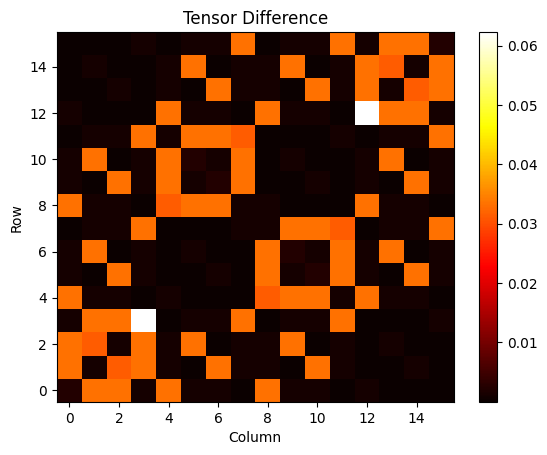

In [723]:
def plot_tensor_difference(tensor1, tensor2):
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    N = tensor1.shape[0]

    # Calculate the absolute difference between the tensors
    diff = np.abs(tensor1 - tensor2)

    # Create a grid for the plot
    xx, yy = np.meshgrid(range(N), range(N))

    # Plot the tensor difference as a grid
    plt.pcolormesh(xx, yy, diff, cmap='hot', shading='auto')
    plt.colorbar()
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title('Tensor Difference')
    plt.show()
plot_tensor_difference(L_output.detach().numpy(), L_desired.detach().numpy())




Final Unitary Fidelity = 
 0.997312605381012
Rho Out: 
 tensor([[ 1.1008e-03-3.5062e-08j,  3.3767e-05-1.4011e-05j,
         -3.0621e-02+1.2671e-02j, -7.7882e-04+7.7779e-04j],
        [ 3.3752e-05+1.4021e-05j,  8.9869e-07+1.0414e-08j,
         -1.1006e-03-5.3609e-07j, -3.3853e-05+1.3897e-05j],
        [-3.0622e-02-1.2671e-02j, -1.1007e-03+1.7945e-07j,
          9.9780e-01+7.8869e-08j,  3.0621e-02-1.2672e-02j],
        [-7.7880e-04-7.7780e-04j, -3.3763e-05-1.4024e-05j,
          3.0622e-02+1.2672e-02j,  1.1007e-03-5.4152e-08j]],
       grad_fn=<ViewBackward0>)
Rho Desired: 
 tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])
Rho fidelity:  0.9977953433990479


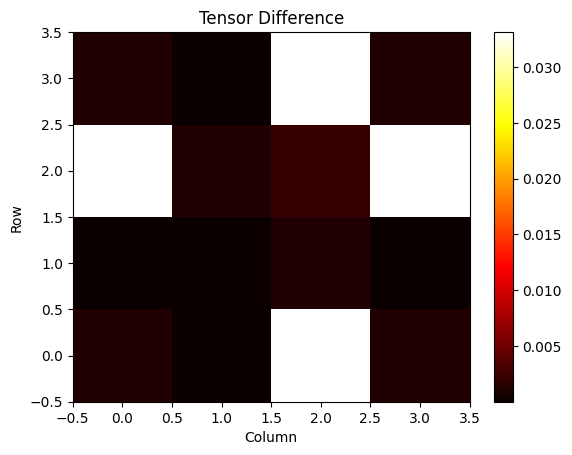

In [724]:
# print("Output superoperator, \n ",L_output)
# print("Desired superoperator, \n ", L_desired)
print("Final Unitary Fidelity = \n",fid.item())

# See what L_f does to initial state
rho_out = torch.matmul(
            L_output, rho0.view(-1,)
        )

def matrix_sqrt(A):
    w,v = torch.linalg.eig(A)
    sqrt_A = torch.chain_matmul(v, torch.diag(w), torch.inverse(v))
    return sqrt_A


def fidelity_states(rho, sigma):
    # rho is output 
    sqrt_rho = matrix_sqrt(rho)
    temp_mat = torch.mm(sqrt_rho, torch.mm(sigma, sqrt_rho))
    return torch.real(torch.trace(matrix_sqrt(temp_mat)))

rho_out = rho_out.view(2**N,2**N)
rho_theoretical = rho_desired.view(2**N,2**N)

print("Rho Out: \n", rho_out)
print("Rho Desired: \n", rho_theoretical)
print("Rho fidelity: ", fidelity_states(rho_out,rho_theoretical).item())
plot_tensor_difference(rho_out.detach().numpy(), rho_theoretical.detach().numpy())


# X,Y,Z = get_xyz_state(evolve_rho(rho0, g, B_rf, phi, J, L, N, dispersive=isDispersive)[-1])
# print("X,Y,Z = ({}, {}, {})".format(X,Y,Z))

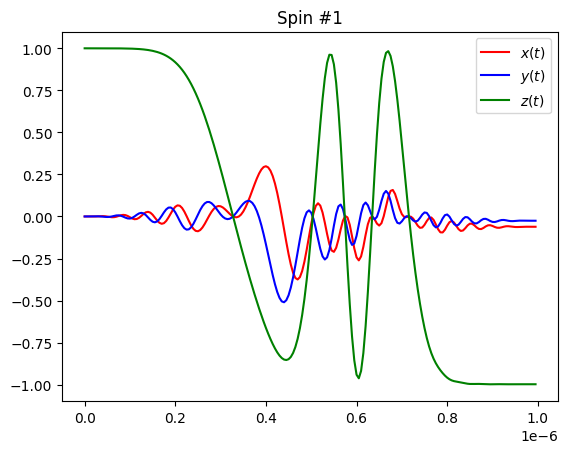

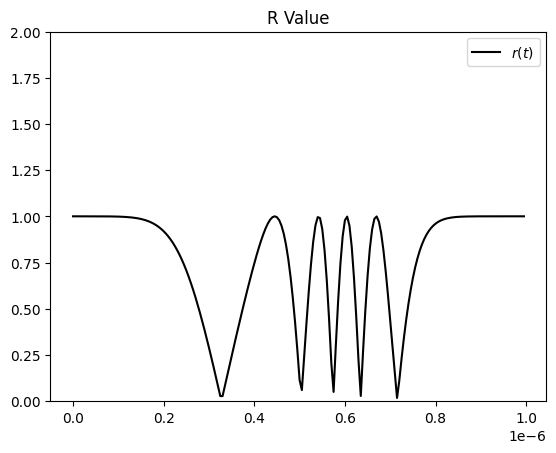

Starting: [8.586981126157411e-11, 3.6197692065975673e-10, 0.9999998807907104] 

Ending: [-0.061310283839702606, -0.025370324030518532, -0.9977952837944031]


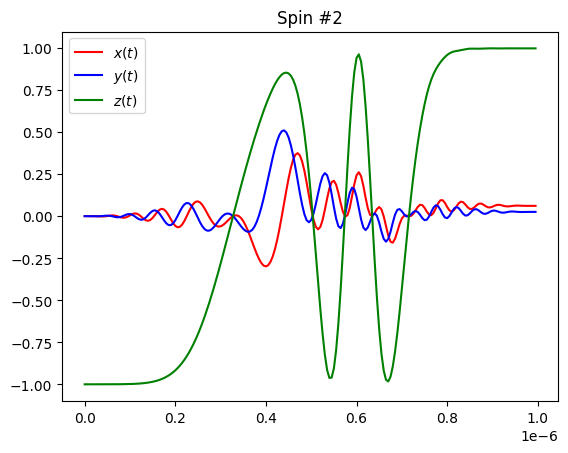

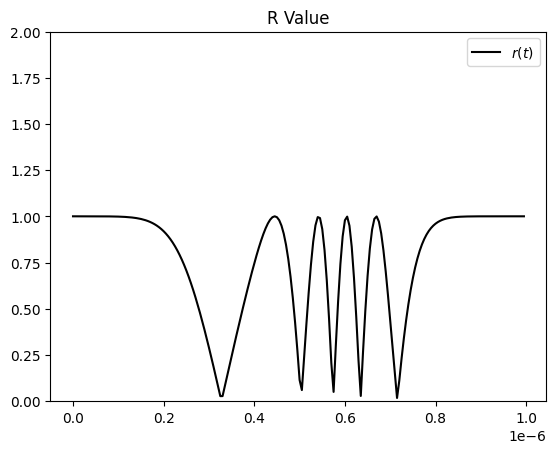

Starting: [-8.58697973837863e-11, -3.619768929041811e-10, -0.9999998807907104] 

Ending: [0.06131037324666977, 0.025371354073286057, 0.9977953433990479]


In [725]:
for i in range(1,N+1):
    bloch_animation(i, evolve_rho(rho0, g, B_rf, phi, J, L, N, dispersive=isDispersive).detach().numpy(), rho_theoretical, plot=True, bloch_sphere=True)

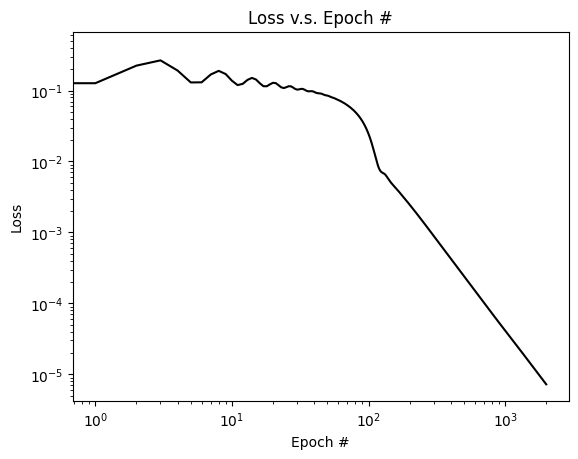

torch.Size([2, 200])


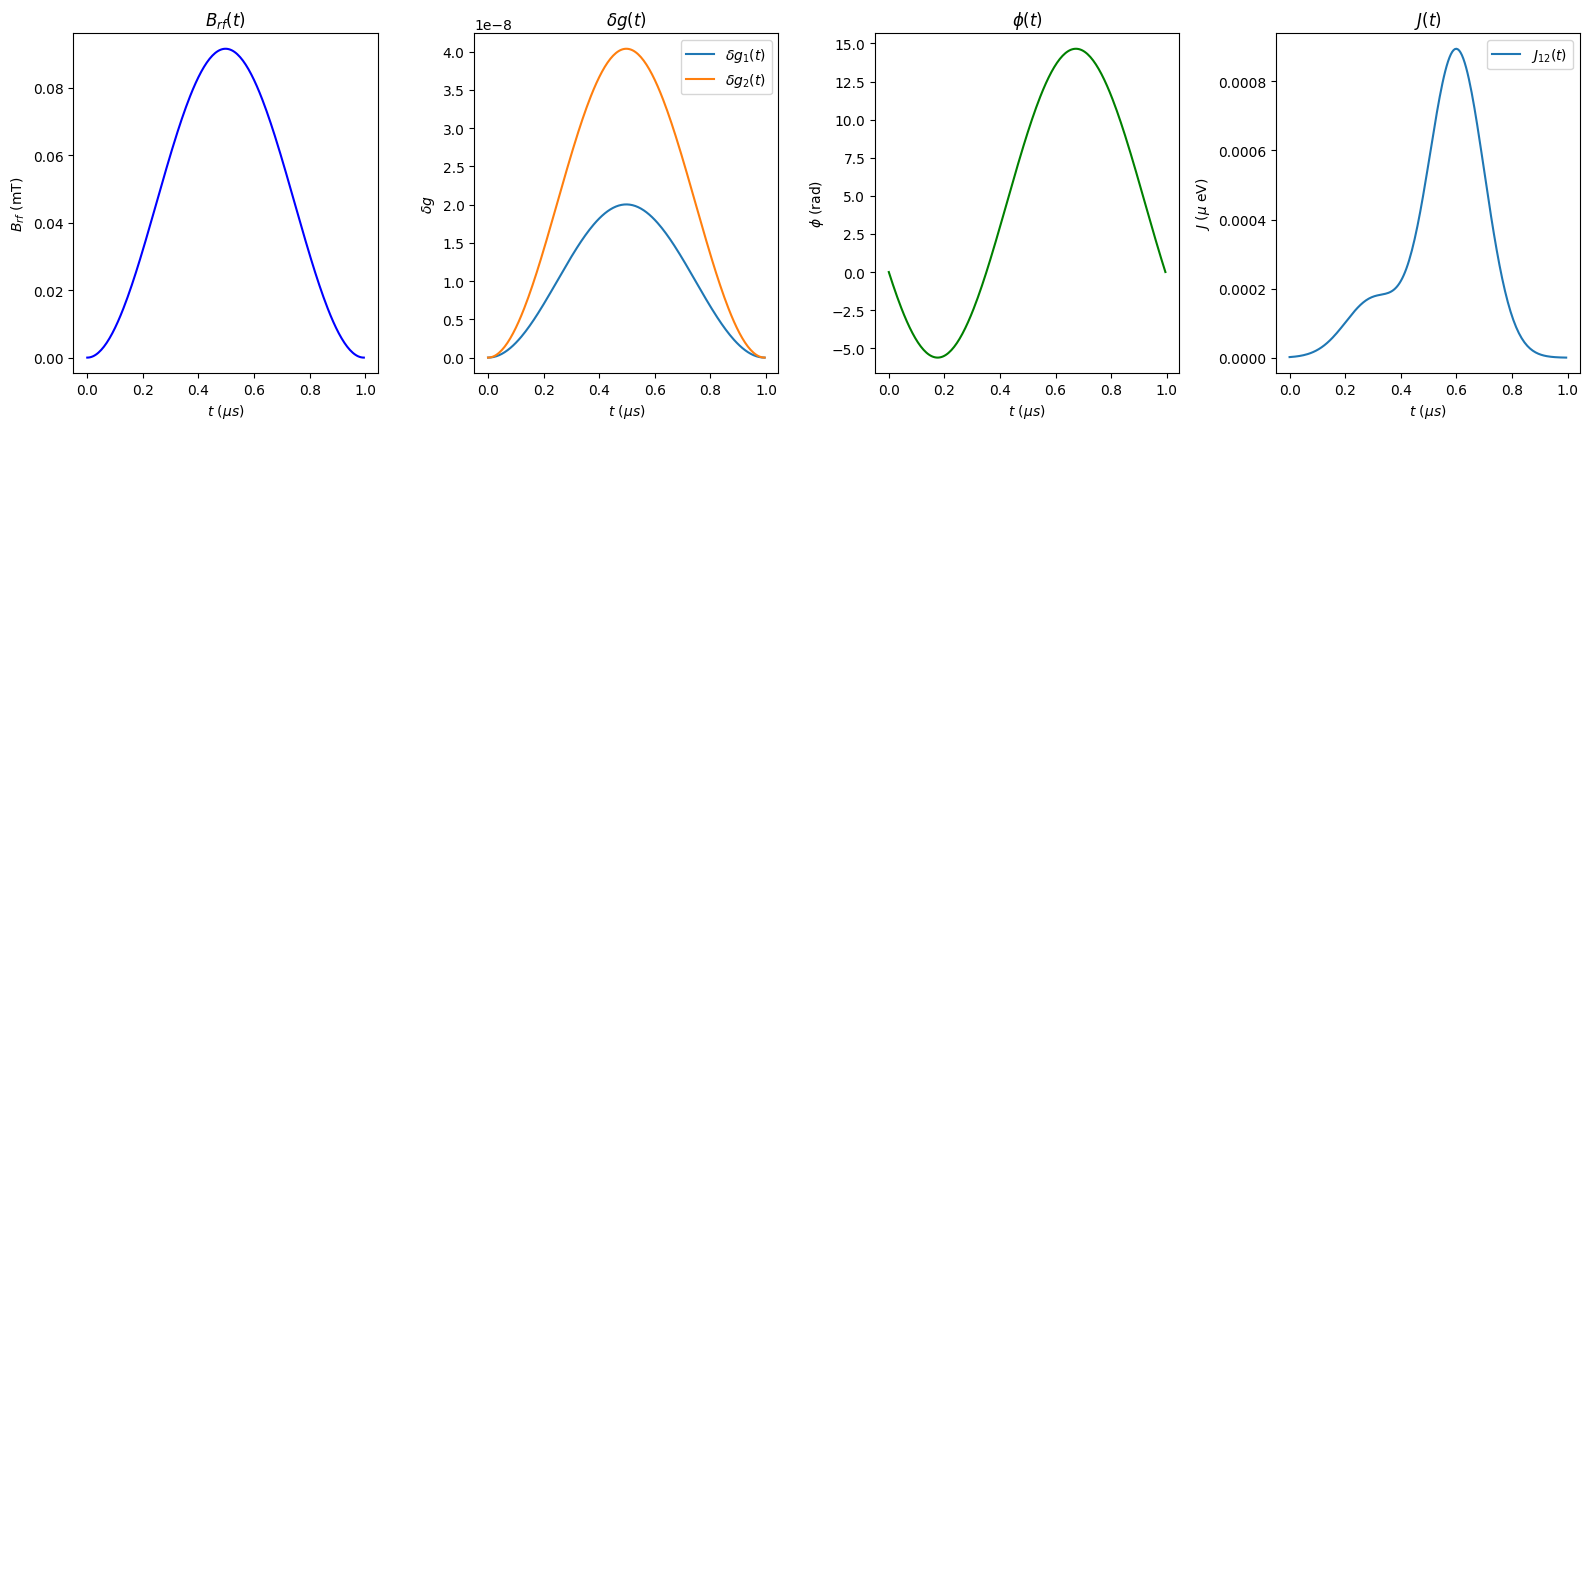

In [726]:

# Print cost fxn 
plt.loglog(loss_array, 'k')
plt.title("Loss v.s. Epoch #")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.savefig('./results/loss.png', dpi=350, bbox_inches="tight")
plt.show()

# Show trained parameters
plt.plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
plt.title(r"$B_{rf}(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$B_{rf}\ $(mT)")
plt.savefig('./results/B_rf.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show() 

# Plot g
print(g.shape)
for i in range(g.shape[0]):
    plt.plot(1e6 * t_units, g[i].detach().numpy(), label=f"$\delta g_{i+1}(t)$")
plt.title(r"$\delta g(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\delta g$")
plt.legend(loc='best')
plt.savefig('./results/delta_g.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show() 

plt.plot(1e6 * t_units, phi.detach().numpy(), 'g')
plt.title(r"$\phi(t)$")
plt.xlabel(r'$t\ (\mu s)$')
plt.ylabel(r"$\phi$ (rad)")
plt.savefig('./results/phi.png', dpi=350, bbox_inches="tight")
plt.close()
# plt.show()

if N>=2:
    # Plot J
    for i in range(J.shape[0]):
        plt.plot(1e6 * t_units, J[i].detach().numpy()/((6.242e-18) * 1e-6),label= r"$J_{{{}{}}}(t)$".format(i+1, i+2))
    plt.title(r"$J(t)$")
    plt.xlabel(r'$t\ (\mu s)$')
    plt.ylabel(r"$J$ ($\mu$eV)")
    plt.legend(loc='best')
    plt.savefig('./results/J.png', dpi=350, bbox_inches="tight")
    plt.close()
    # plt.show()


# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Plot B_rf
axs[0, 0].plot(1e6 * t_units, 1e3 * B_rf.detach().numpy(), 'b')
axs[0, 0].set_title(r"$B_{rf}(t)$")
axs[0, 0].set_xlabel(r'$t\ (\mu s)$')
axs[0, 0].set_ylabel(r"$B_{rf}\ $(mT)")

# Plot g
for i in range(g.shape[0]):
    axs[0, 1].plot(1e6 * t_units, g[i].detach().numpy(), label=f"$\delta g_{i+1}(t)$")
axs[0, 1].set_title(r"$\delta g(t)$")
axs[0,1].set_xlabel(r'$t\ (\mu s)$')
axs[0, 1].set_ylabel(r"$\delta g$")
axs[0, 1].legend()

# Plot phi
axs[0, 2].plot(1e6 * t_units, phi.detach().numpy(), 'g')
axs[0, 2].set_title(r"$\phi(t)$")
axs[0, 2].set_xlabel(r'$t\ (\mu s)$')
axs[0, 2].set_ylabel(r"$\phi$ (rad)")

if N >= 2:
    # Plot J
    for i in range(J.shape[0]):
        axs[0, 3].plot(1e6 * t_units, J[i].detach().numpy()/((6.242e-18) * 1e-6),label= r"$J_{{{}{}}}(t)$".format(i+1, i+2))
    axs[0, 3].set_title(r"$J(t)$")
    axs[0, 3].set_xlabel(r'$t\ (\mu s)$')
    axs[0, 3].set_ylabel(r"$J$ ($\mu$ eV)")
    axs[0, 3].legend()
    # axs[0,3].set_ylim([0,1])

# Remove empty subplots
for i in range(1, 4):
    for j in range(4):
        axs[i, j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
